In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import matplotlib.pyplot as plt
from symmetry_lens import *

In [11]:
MODEL_PATH = "/home/onur/Code/SymmetryLens/ablation_study/ablated:alignment/epochs/ep9670.h5"
MODEL_SAVING_DIR = "model_weights_mnist"
NUM_TRAINING_EPOCHS = 10000
BATCH_SIZE = 10800
OUTPUT_REPRESENTATION = "natural"
SYNTHETIC_DATASET_FEATURES = [
    {
        "type": "mnist_slices"
    }
]
NOISE_STD = 0.0
WAVEFORM_TIMESTEPS=27
USE_PADDED_GENERATOR=True

In [12]:
# Create a data generator.
dg = make_data_generator(dims=1,
                         batch_size=BATCH_SIZE,
                         features=SYNTHETIC_DATASET_FEATURES,
                         waveform_timesteps=WAVEFORM_TIMESTEPS,
                         noise_normalized_std=NOISE_STD,
                         output_representation=OUTPUT_REPRESENTATION,
                         p_exist=0.5,
                         num_of_lots=5)

In [13]:
# Create model and load weights.
x_init = np.random.normal(size=(BATCH_SIZE, WAVEFORM_TIMESTEPS, 1))
model = create_model(zero_padding_size=WAVEFORM_TIMESTEPS,
                     use_zero_padding=True,
                     conditional_probability_estimator_hidden_layer_size = 108*4,
                     num_uniformity_scales=1)
model.compile()
model(x_init)
model.load_weights(MODEL_PATH)

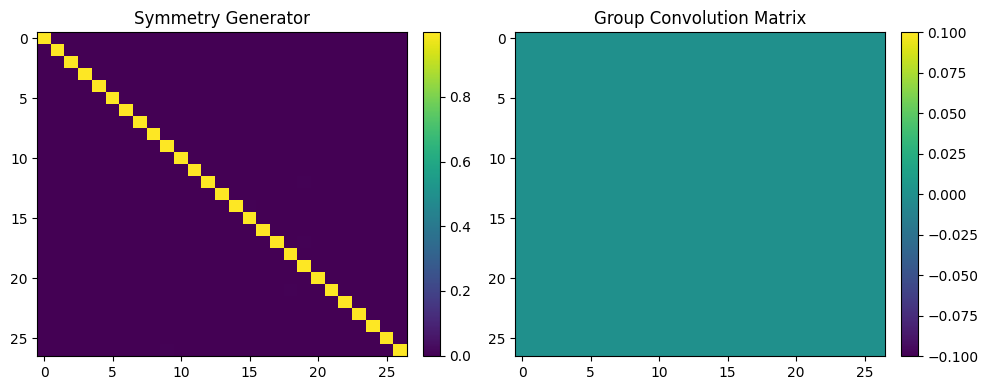

In [14]:
# Plot learned symmetry generator and group correlation map. 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

if USE_PADDED_GENERATOR:
    im1 = ax[0].imshow(model.symmetry_generator[WAVEFORM_TIMESTEPS:-WAVEFORM_TIMESTEPS, 
                                                WAVEFORM_TIMESTEPS:-WAVEFORM_TIMESTEPS], 
                    aspect="auto", cmap="viridis")
else:
    im1 = ax[0].imshow(model.symmetry_generator, 
                    aspect="auto", cmap="viridis")
    
ax[0].set_title("Symmetry Generator")  # Add title to the first subplot

im2 = ax[1].imshow(model.group_convolution_matrix, aspect="auto", cmap="viridis")
ax[1].set_title("Group Convolution Matrix")  # Add title to the second subplot

fig.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04)

# Adjust layout for better spacing
plt.tight_layout()

In [33]:
x = dg.sample_batch_of_data()
print("Batch shape:", x.shape)  # Expected: (BATCH_SIZE, WAVEFORM_TIMESTEPS, 1)
y = model(x)
y = y.numpy()

Batch shape: (10800, 27, 1)


In [34]:
# Randomly select some samples.
random_seed = 42
np.random.seed(random_seed)
total_samples = x.shape[0]
num_pairs = 9
selected_indices = np.random.choice(total_samples, size=num_pairs, replace=False)
print("Selected indices:", selected_indices)

Selected indices: [ 1254  9033  2523 10670  8637  4565  2614  5034  4089]


ValueError: x and y must have same first dimension, but have shapes (7,) and (27,)

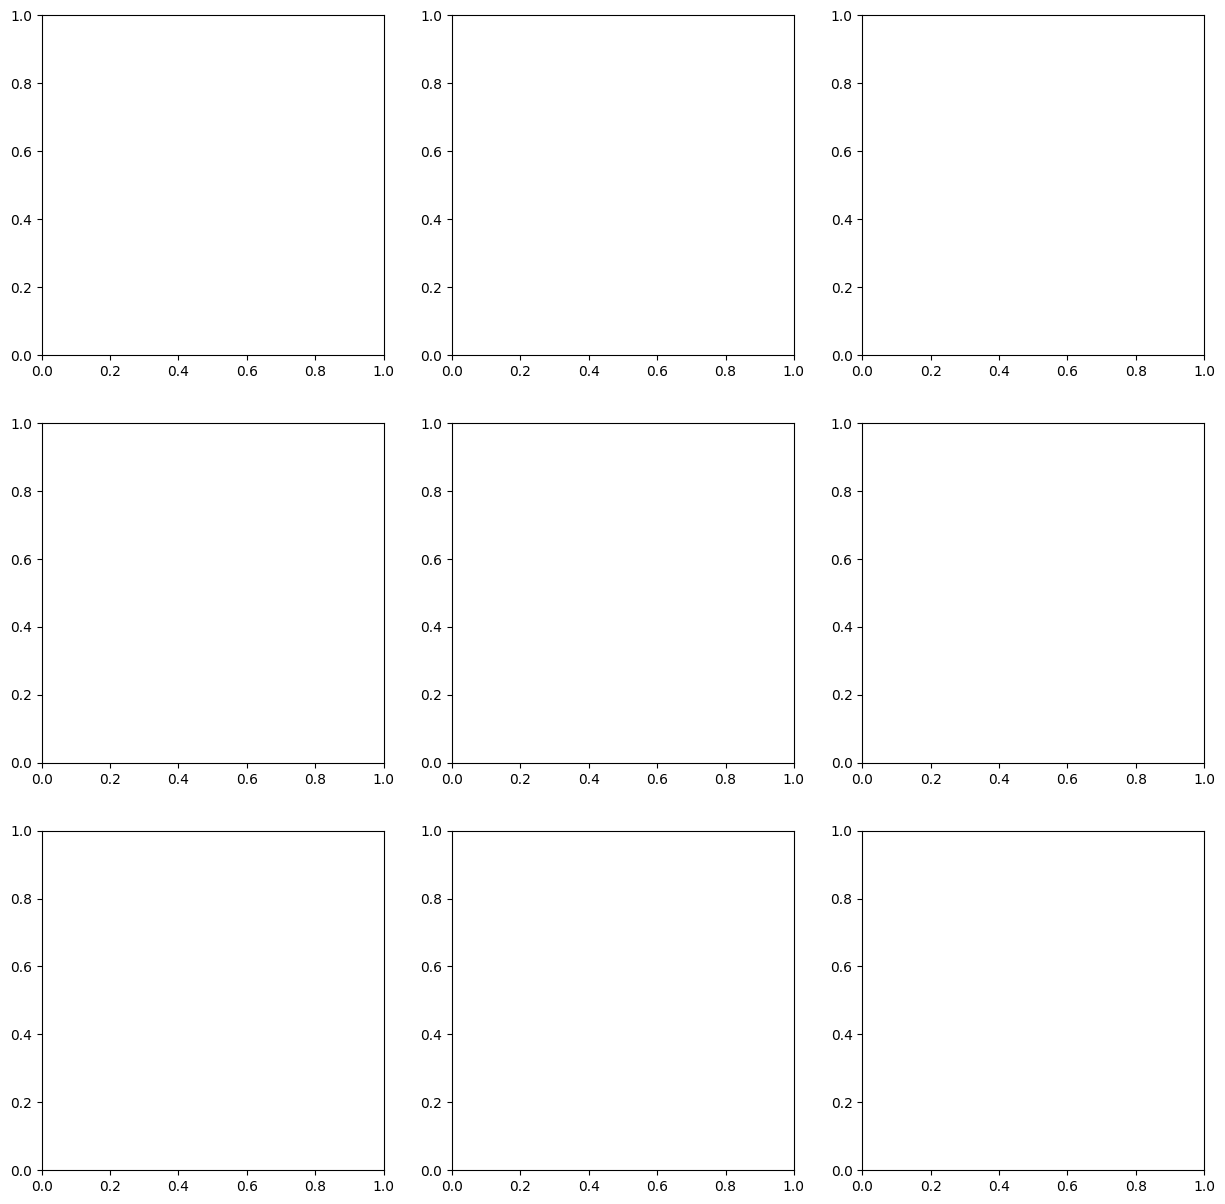

In [35]:
# Plot pairs of inputs and outputs.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))  # Adjust figsize as needed
axes = axes.flatten()

for i, idx in enumerate(selected_indices):
    ax = axes[i]
    
    input_signal = x[idx].squeeze()   # Shape: (33,)
    output_signal = y[idx].squeeze()  # Shape: (33,)
    
    timesteps = np.arange(7)
    
    ax.plot(timesteps, input_signal, color='red', label='Input')
    ax.plot(timesteps, output_signal, color='blue', label='Output')
    
    ax.set_title(f'Pair {i+1} (Index: {idx})')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Signal Value')
    ax.legend()
    ax.grid(True)

plt.tight_layout()

# Show the Figure
plt.show()
plt.clf() 